Found 0 images belonging to 0 classes.
Found 6585 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


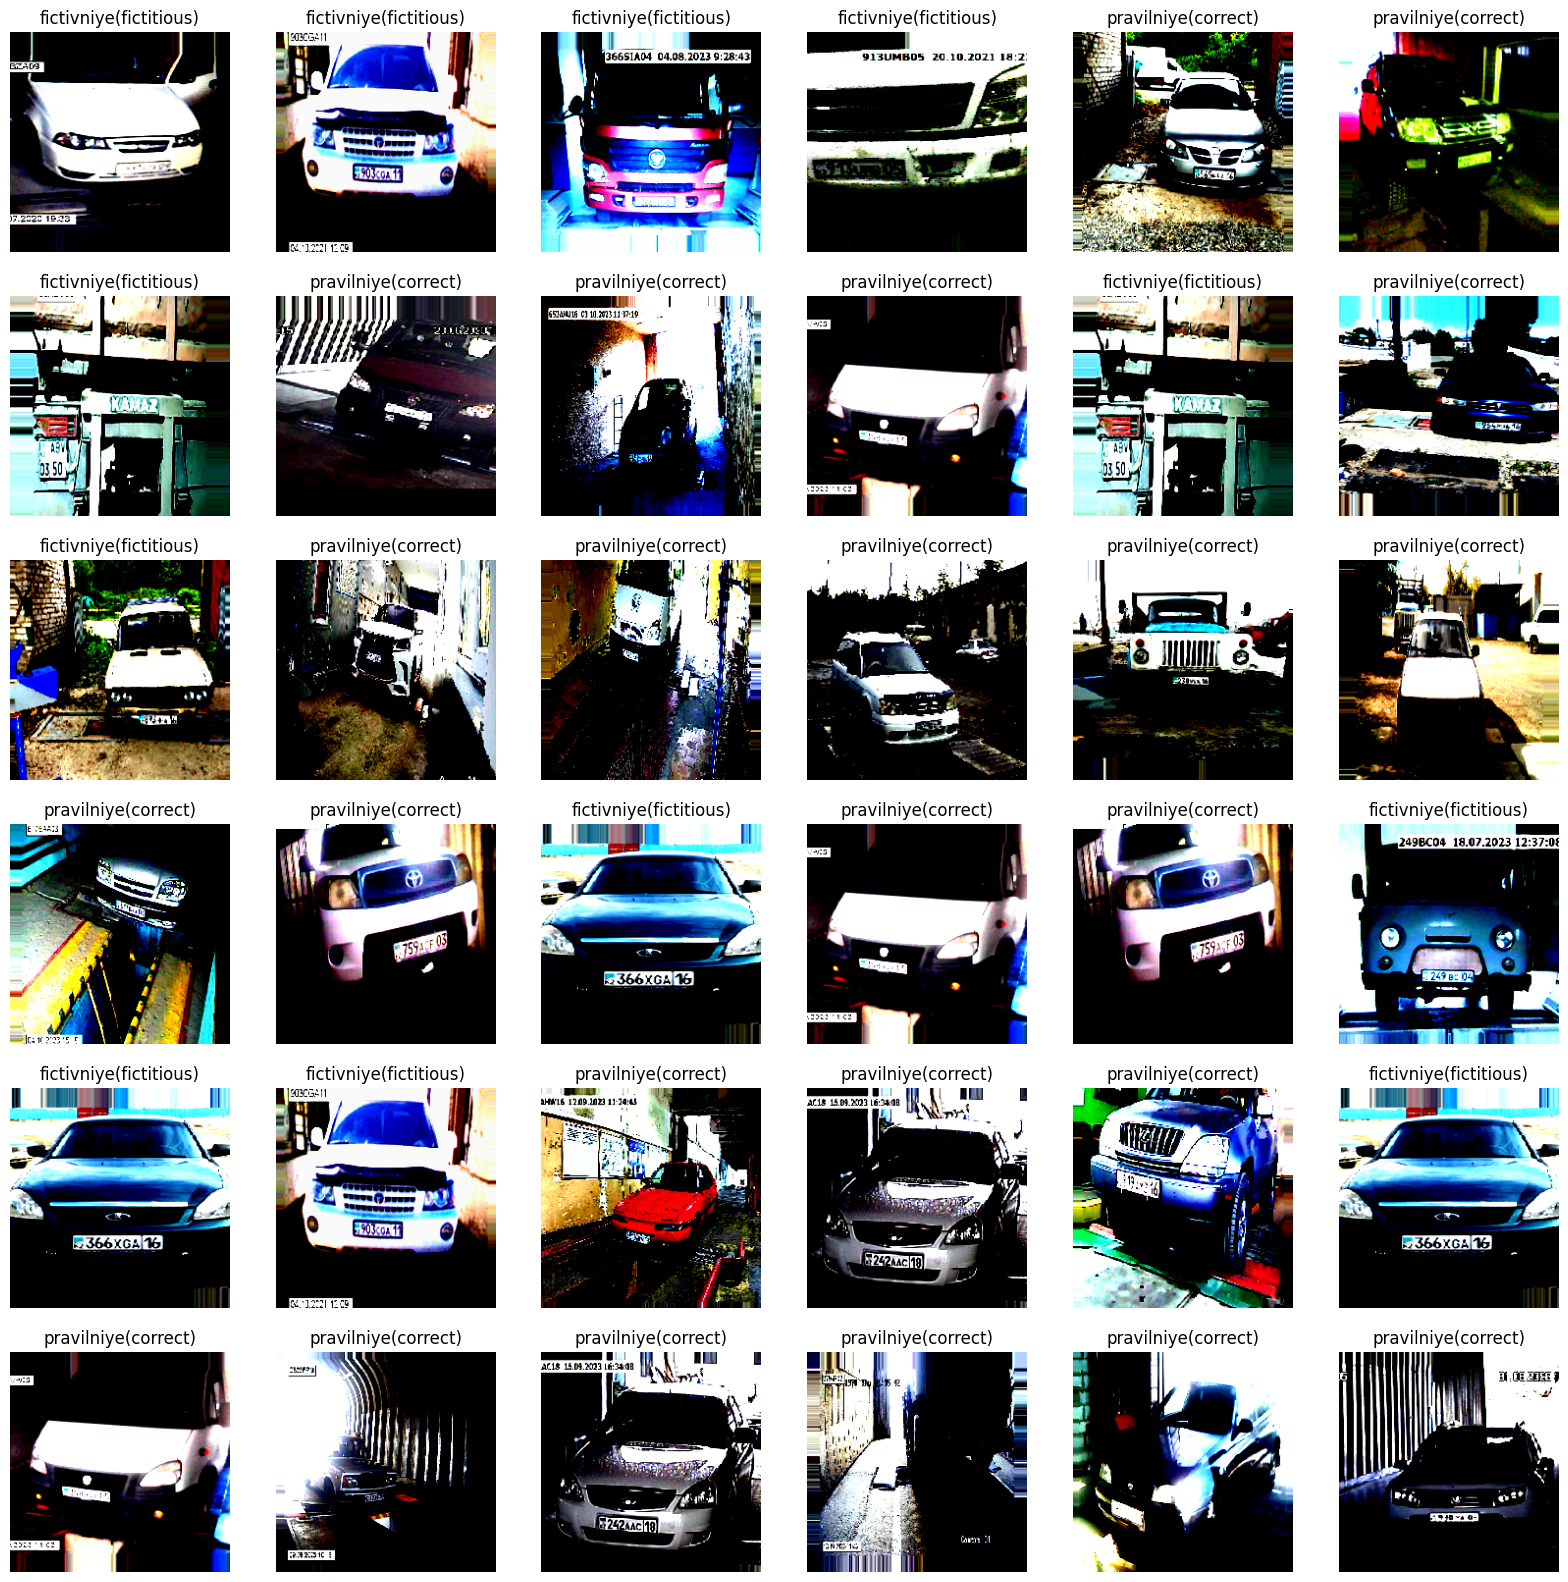

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Define the paths to your dataset folders
dataset_dir = '/kaggle/input/datasaur/techosmotr/techosmotr/train/'
train_dir = os.path.join(dataset_dir, 'train')
output_dir = '/kaggle/input/datasaur/train_all'  # Create a new directory to store the combined dataset


train_path = '/kaggle/input/datasaur/techosmotr/techosmotr/train'
test_path = '/kaggle/input/datasaur/techosmotr/techosmotr/test'


train_datagen = ImageDataGenerator(
#     rotation_range=0.10,
#     width_shift_range=0.10,
#     height_shift_range=0.10,
#     shear_range=0.10,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zoom_range=0.30,
    horizontal_flip=False,
    brightness_range=[0.5, 1.5],
    channel_shift_range= 20,
#     fill_mode='constant',
    rescale=1.0/255,
#     validation_split=0.2  # This sets aside 20% of the data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

size_images = 224
batch_size = 64

# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify that this is the training set
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify that this is the validation set
)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

    
Show_Images(train_generator)
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

num_classes = 2

from sklearn.metrics import f1_score


# Load a pre-trained ResNet model
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x) # add regularization
x = Dropout(0.5)(x) # add dropout. why?
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])




# Train the model

# add saving models to track accuracy

from tensorflow.keras.callbacks import ModelCheckpoint

# Define a callback to save the model at each epoch
model_checkpoint = ModelCheckpoint(
    'model_weights_epoch_{epoch:02d}.h5',  # File name pattern for saved models
    save_best_only=False,  # Set to True to save only the best model
    save_weights_only=True,  # Save only the model's weights
    monitor='val_loss',  # Monitor validation loss
    mode='auto',  # Automatically determine whether to minimize or maximize the monitored quantity
    verbose=1  # Print messages when saving
)

history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=6,validation_data=validation_generator,validation_steps=len(validation_generator), callbacks=[model_checkpoint])

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=5,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // batch_size,
#     callbacks=[callback]
# )

# Optionally, fine-tune the top layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=5,validation_data=validation_generator,validation_steps=len(validation_generator), callbacks=[model_checkpoint])

Epoch 1/6
103/103 [==============================] - ETA: 0s - loss: 2.7997 - accuracy: 0.8395
Epoch 1: saving model to model_weights_epoch_01.h5
103/103 [==============================] - 123s 1s/step - loss: 2.7997 - accuracy: 0.8395
Epoch 2/6
103/103 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.8671
Epoch 2: saving model to model_weights_epoch_02.h5
103/103 [==============================] - 119s 1s/step - loss: 0.5674 - accuracy: 0.8671
Epoch 3/6
103/103 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.8653
Epoch 3: saving model to model_weights_epoch_03.h5
103/103 [==============================] - 117s 1s/step - loss: 0.4687 - accuracy: 0.8653
Epoch 4/6
103/103 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8661
Epoch 4: saving model to model_weights_epoch_04.h5
103/103 [==============================] - 119s 1s/step - loss: 0.4305 - accuracy: 0.8661
Epoch 5/6
103/103 [==============================] - ETA

In [19]:
import os
test_path = '/kaggle/input/datasaur/techosmotr/techosmotr/test'
import pandas as pd


test_folder = '/kaggle/input/datasaur/techosmotr/techosmotr/test'  # Replace with the actual path to your test image folder
size_images = 224  # Adjust the size according to your model's input size
# images = []






# for image_file in os.listdir(test_folder):
#     if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Filter by supported image file extensions
#         image_path = os.path.join(test_folder, image_file)
#         img = cv2.imread(image_path)
#         img = cv2.resize(img, (224, 224))
#         img = img / 255.0  # Rescale pixel values to [0, 1]
#         images.append(img)

        
        
        
images = []
image_names = []

for image_file in os.listdir(test_folder):
    if image_file.endswith(('.jpg', '.jpeg', '.png')):  # Filter by supported image file extensions
        image_path = os.path.join(test_folder, image_file)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (size_images, size_images))
        img = img / 255.0  # Rescale pixel values to [0, 1]
        
        image_name_without_extension = os.path.splitext(image_file)[0]
        image_names.append(image_name_without_extension) 
        images.append(img)
        
        
        
        

# Convert the list of images to a single numpy array
images_batch = np.array(images)

# Make predictions
predictions = model.predict(images_batch)

# Convert predictions to 0 or 1 based on a threshold (0.5 in this case)
threshold = 0.5
binary_predictions = [1 if pred[0] > threshold else 0 for pred in predictions]


# Create a DataFrame to store the results
results_df = pd.DataFrame({'file_index': image_names, 'class': binary_predictions})

# Save the results to a CSV file
results_df.to_csv('results.csv', index=False)
        
print(results_df)

25/25 [==============================] - 2s 56ms/step
    file_index  class
0     78942502      0
1     72473767      0
2     72306150      1
3     79367589      0
4     76954750      1
..         ...    ...
772   79797333      0
773   76019137      1
774   78672316      0
775   70007467      0
776   73885075      0

[777 rows x 2 columns]
